In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
import os

# To remove warnings related to type change
import warnings
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None  

df = pd.read_csv('dataset/pizza_v1.csv')
df.head()

,company,price_rupiah,diameter,topping,variant,size,extra_sauce,extra_cheese
0,A,"Rp235,000",22.0,chicken,double_signature,jumbo,yes,yes
1,A,"Rp198,000",20.0,papperoni,double_signature,jumbo,yes,yes
2,A,"Rp120,000",16.0,mushrooms,double_signature,reguler,yes,yes
3,A,"Rp155,000",14.0,smoked beef,double_signature,reguler,yes,no
4,A,"Rp248,000",18.0,mozzarella,double_signature,jumbo,yes,no


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   company       129 non-null    object 
 1   price_rupiah  129 non-null    object 
 2   diameter      129 non-null    float64
 3   topping       129 non-null    object 
 4   variant       129 non-null    object 
 5   size          129 non-null    object 
 6   extra_sauce   129 non-null    object 
 7   extra_cheese  129 non-null    object 
dtypes: float64(1), object(7)
memory usage: 8.2+ KB


In [3]:
# converting price in known format
df['price_rupiah'] = df['price_rupiah'].str.replace('Rp', '').str.replace(',', '')

df['price_rupiah'] = pd.to_numeric(df['price_rupiah'])

df['price_rupiah'] = df['price_rupiah'].astype('float64')

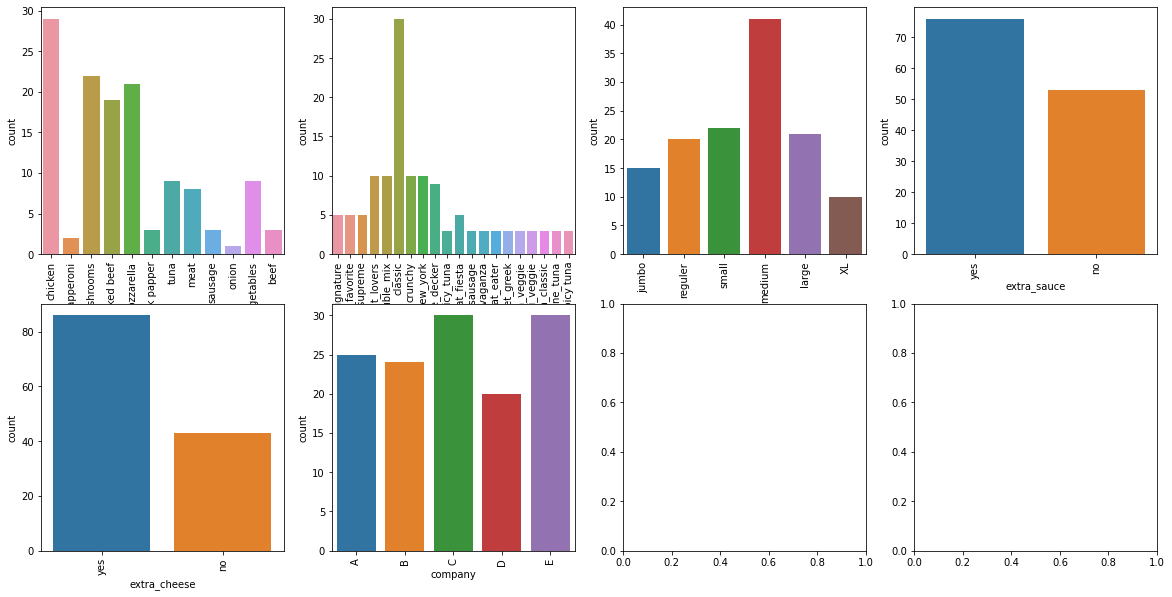

In [4]:
categorical = ['topping','variant','size','extra_sauce','extra_cheese','company']
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for variable, subplot in zip(categorical, ax.flatten()):
    sns.countplot(df[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

In [5]:
df.nunique()

company          5
price_rupiah    43
diameter        11
topping         12
variant         20
size             6
extra_sauce      2
extra_cheese     2
dtype: int64

In [6]:
# null implification
# Null values in rows
df.isnull().sum()

company         0
price_rupiah    0
diameter        0
topping         0
variant         0
size            0
extra_sauce     0
extra_cheese    0
dtype: int64

In [7]:
# we will apply label encoding
labelEncoder = LabelEncoder()

# we will not create class in this case as we have no value to predict in real time for now 
# Encoding Data Pizza Company
df['company'] = labelEncoder.fit_transform(df['company'])

# Encoding Data Pizza Topping
df['topping'] = labelEncoder.fit_transform(df['topping'])

# Encoding Data Pizza Variant
df['variant'] = labelEncoder.fit_transform(df['variant'])

# Encoding Data Pizza Size
df['size'] = labelEncoder.fit_transform(df['size'])

# Encoding Data Pizza Ext Sauce
df['extra_sauce'] = labelEncoder.fit_transform(df['extra_sauce'])

# Encoding Data Pizza Ext Cheese
df['extra_cheese'] = labelEncoder.fit_transform(df['extra_cheese'])
df

,company,price_rupiah,diameter,topping,variant,size,extra_sauce,extra_cheese
0,0,235000.0,22.0,2,8,1,1,1
1,0,198000.0,20.0,7,8,1,1,1
2,0,120000.0,16.0,5,8,4,1,1
3,0,155000.0,14.0,9,8,4,1,0
4,0,248000.0,18.0,4,8,1,1,0
...,...,...,...,...,...,...,...,...
124,4,39000.0,8.5,10,16,5,1,1
125,4,72000.0,12.0,10,16,3,1,1
126,4,99000.0,14.0,10,16,2,1,1
127,4,44000.0,8.5,3,0,5,1,0


In [8]:
df = df.astype('float64')
df

,company,price_rupiah,diameter,topping,variant,size,extra_sauce,extra_cheese
0,0.0,235000.0,22.0,2.0,8.0,1.0,1.0,1.0
1,0.0,198000.0,20.0,7.0,8.0,1.0,1.0,1.0
2,0.0,120000.0,16.0,5.0,8.0,4.0,1.0,1.0
3,0.0,155000.0,14.0,9.0,8.0,4.0,1.0,0.0
4,0.0,248000.0,18.0,4.0,8.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...
124,4.0,39000.0,8.5,10.0,16.0,5.0,1.0,1.0
125,4.0,72000.0,12.0,10.0,16.0,3.0,1.0,1.0
126,4.0,99000.0,14.0,10.0,16.0,2.0,1.0,1.0
127,4.0,44000.0,8.5,3.0,0.0,5.0,1.0,0.0


In [9]:
df.describe()

,company,price_rupiah,diameter,topping,variant,size,extra_sauce,extra_cheese
count,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000
mean,2.046512,87151.162791,12.976744,5.294574,8.155039,2.868217,0.589147,0.666667
std,1.435381,44706.097732,3.272674,3.204984,5.265527,1.470437,0.493907,0.473242
min,0.000000,23500.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,51000.000000,12.000000,2.000000,4.000000,2.000000,0.000000,0.000000
50%,2.000000,78000.000000,12.000000,5.000000,6.000000,3.000000,1.000000,1.000000
75%,3.000000,105000.000000,14.000000,9.000000,13.000000,4.000000,1.000000,1.000000
max,4.000000,248000.000000,22.000000,11.000000,19.000000,5.000000,1.000000,1.000000


In [10]:
#define function to calculate cv/Coefficient of Variation
cv = lambda x: np.std(x, ddof=1) / np.mean(x) * 100 

df.apply(cv)

company         70.137955
price_rupiah    51.297190
diameter        25.219528
topping         60.533376
variant         64.567775
size            51.266589
extra_sauce     83.834158
extra_cheese    70.986354
dtype: float64

In [11]:
# cv of price is less then mean and avg of data so we can say that estimate will be precise 

# NOw we will find coorelation
df.corr()

,company,price_rupiah,diameter,topping,variant,size,extra_sauce,extra_cheese
company,1.000000,-0.300033,-0.182710,0.002093,-0.109497,0.021434,-0.038954,0.034503
price_rupiah,-0.300033,1.000000,0.826977,-0.077875,0.130395,-0.551606,0.083859,0.011817
diameter,-0.182710,0.826977,1.000000,-0.178475,0.193343,-0.836722,-0.063957,0.055488
topping,0.002093,-0.077875,-0.178475,1.000000,0.255129,0.145894,0.042505,-0.012019
variant,-0.109497,0.130395,0.193343,0.255129,1.000000,-0.255651,-0.029388,0.268582
size,0.021434,-0.551606,-0.836722,0.145894,-0.255651,1.000000,0.226068,-0.119754
extra_sauce,-0.038954,0.083859,-0.063957,0.042505,-0.029388,0.226068,1.000000,-0.089131
extra_cheese,0.034503,0.011817,0.055488,-0.012019,0.268582,-0.119754,-0.089131,1.000000


[]

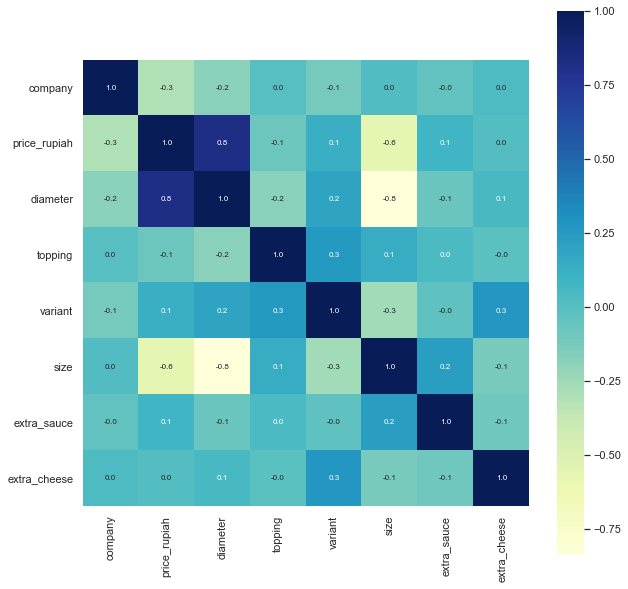

In [12]:
sns.set_theme(color_codes=True, style='darkgrid', palette='deep', font='sans-serif')
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), cbar=True, square=True, fmt='.1f', annot=True, annot_kws={'size': 8}, cmap='YlGnBu')
plt.plot()

<AxesSubplot:>

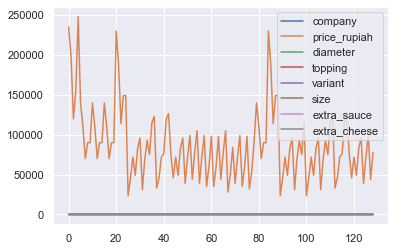

In [13]:
df.plot()

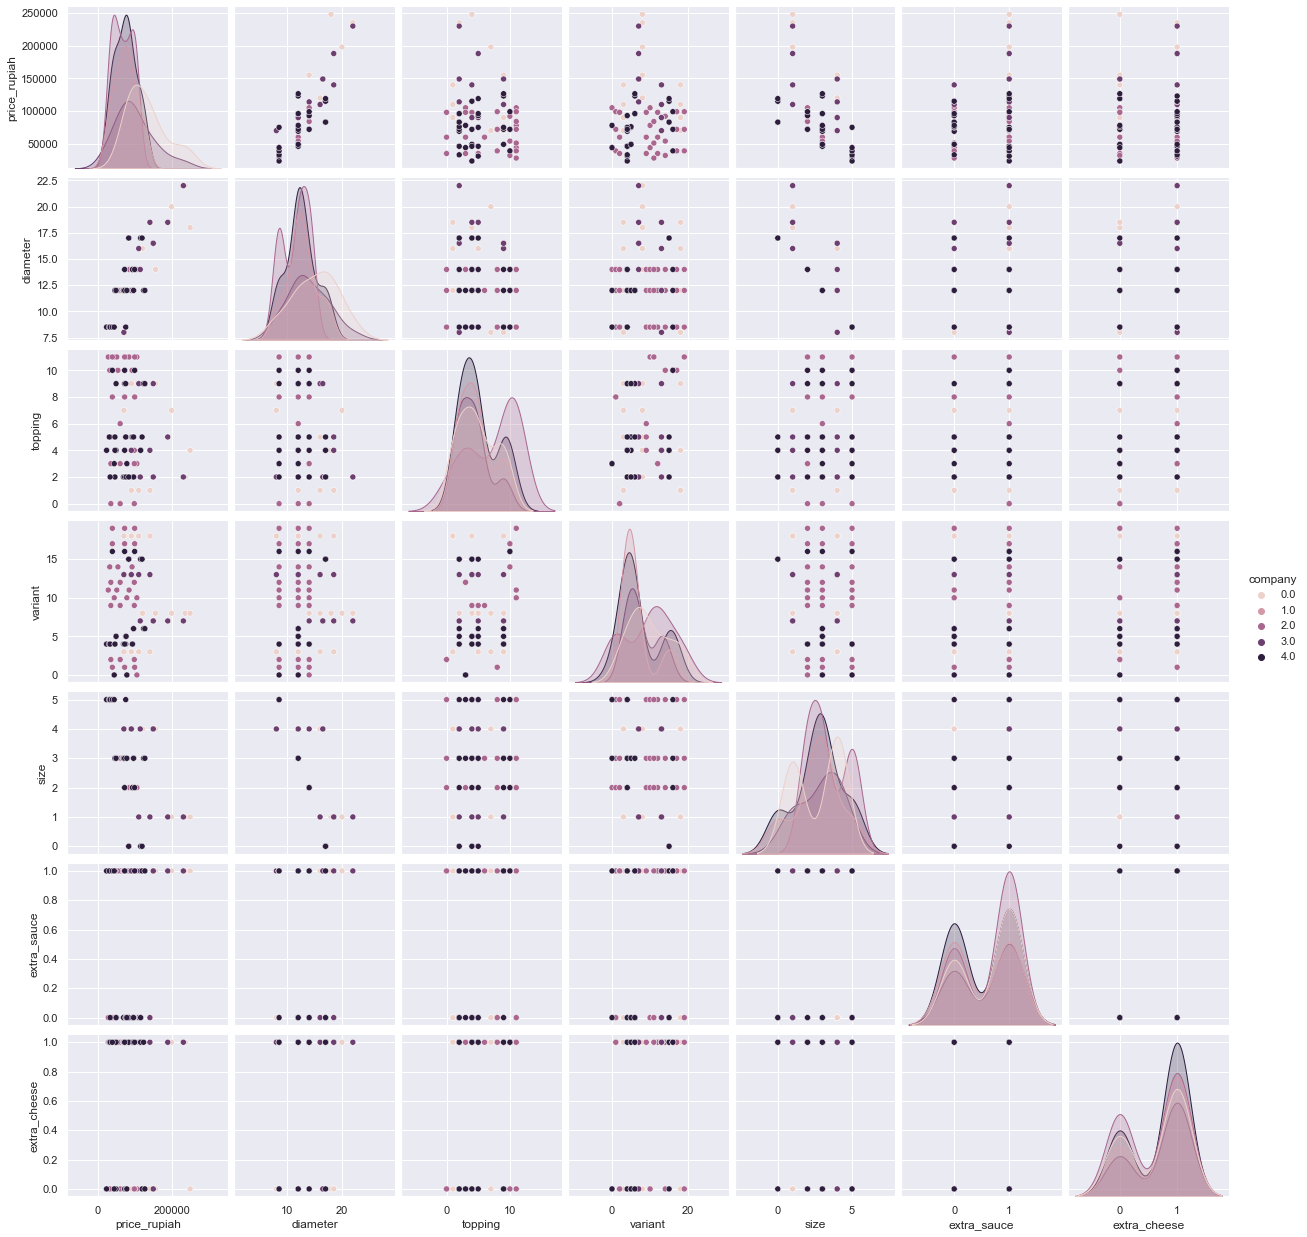

In [14]:
sns.pairplot(df,hue="company")

In [15]:
# split data 
X = df.drop(['price_rupiah'], axis=1)
y = df['price_rupiah']
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=.1,
    shuffle=False,
    random_state=0)

# Sklearn DecisionTreeRegressor

In [16]:
# Tree method
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import *
regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(X_train, y_train)

y_predict2 = regressor.predict(X_test)
rmse = (mean_squared_error(y_test, y_predict2, squared=False))
a = round(regressor.score(X_train,y_train)*100,2)
print((rmse/(y_test.max()-y_test.min()))*100, f", {round(a,2)}%")

14.263719331505891 , 100.0%


<AxesSubplot:xlabel='Predicted', ylabel='Actuals'>

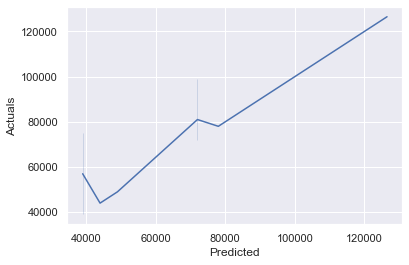

In [17]:
met = pd.DataFrame(zip(y_predict2 , y_test),columns=['Predicted','Actuals'])

# we will use graph to check how far are we off from our actual parameters
sns.lineplot( x=met['Predicted'], y=met["Actuals"])

In [18]:
met.nunique()

Predicted    10
Actuals      12
dtype: int64

In [19]:
met

,Predicted,Actuals
0,119000.0,119000.0
1,126500.0,126500.0
2,39000.0,75000.0
3,46000.0,46000.0
4,72000.0,72000.0
5,49000.0,49000.0
6,83000.0,83000.0
7,96000.0,96000.0
8,39000.0,39000.0
9,72000.0,72000.0


# XGB gbtree method

In [20]:
regressor = XGBRegressor(
    gamma=0,
    learning_rate=0.1,
    max_depth=5,
    n_estimators=1000,
    n_jobs=16,
    objective='reg:squarederror',
    subsample=0.8,
    scale_pos_weight=0,
    reg_alpha=0,
    reg_lambda=1,
    booster='gbtree'
)

model = regressor.fit(X_train, y_train)

In [21]:
# We will create a pipeline 
myPipeline = Pipeline(steps=[('model', model)])

In [22]:
# predict X train
trainPredict = myPipeline.predict(X_train)

# predict X test  
testPredict = myPipeline.predict(X_test)

In [23]:
# X_train y_train

# R Squared 
trainRsquared = metrics.r2_score(y_train, trainPredict)
print(f'R2 : {trainRsquared}')

# Mean Absolute Error
trainMAE = metrics.mean_absolute_error(y_train, trainPredict)
print(f'MAE : {trainMAE}')

#  Mean Squared Error
trainMSE = metrics.mean_squared_error(y_train, trainPredict)
print(f'MSE : {trainMSE}')

#  Root Mean Squared Error
trainRMSE = math.sqrt(metrics.mean_squared_error(y_train, trainPredict))
print(f'RMSE : {trainRMSE}')

# Median
trainM = metrics.median_absolute_error(y_train, trainPredict)
print(f'Median : {trainM}')

R2 : 0.9999999999738813
MAE : 0.15862405711206898
MSE : 0.05513076124520137
RMSE : 0.2347994063987415
Median : 0.095703125


In [24]:
# X_test y_test  

# R Squared 
testRsquared = metrics.r2_score(y_test, testPredict)
print(f'R-Squared : {testRsquared}')

# Mean Absolute Error
testMAE = metrics.mean_absolute_error(y_test, testPredict)
print(f'MAE : {testMAE}')

#  Mean Squared Error
testMSE = metrics.mean_squared_error(y_test, testPredict)
print(f'MSE : {testMSE}')

#  Root Mean Squared Error
testRMSE = math.sqrt(metrics.mean_squared_error(y_test, testPredict))
print(f'RMSE : {testRMSE}')

# Median
testM = metrics.median_absolute_error(y_test, testPredict)
print(f'Median : {testM}')

R-Squared : 0.9458520377949969
MAE : 4337.541766826923
MSE : 39268807.075783364
RMSE : 6266.4828313642865
Median : 2292.1640625


In [25]:
y_test.max(), y_test.min(), testRMSE

(126500.0, 39000.0, 6266.4828313642865)

In [26]:
# normalised RMSE value 
NRMSE = testRMSE/(y_test.max()-y_test.min())
NRMSE*100

7.161694664416328

<AxesSubplot:xlabel='Predicted', ylabel='Actuals'>

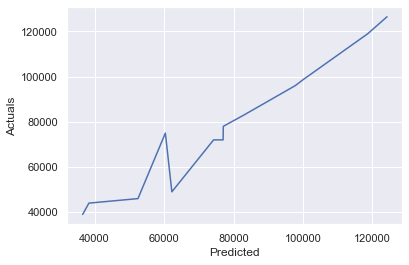

In [27]:
met1 = pd.DataFrame(zip(testPredict , y_test),columns=['Predicted','Actuals'])

# we will use graph to check how far are we off from our actual parameters
sns.lineplot( x=met1['Predicted'], y=met1["Actuals"])

<AxesSubplot:xlabel='Predicted', ylabel='Actuals'>

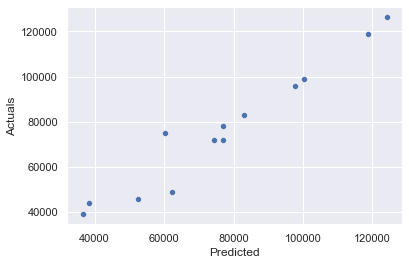

In [28]:
sns.scatterplot( x=met1['Predicted'], y=met1["Actuals"])

In [29]:
# In this case XGB gave better results in prediction
met1

,Predicted,Actuals
0,118668.742188,119000.0
1,124207.835938,126500.0
2,60376.039062,75000.0
3,52485.710938,46000.0
4,74265.578125,72000.0
5,62245.398438,49000.0
6,83000.046875,83000.0
7,97771.632812,96000.0
8,36563.257812,39000.0
9,76997.132812,72000.0
